In [5]:
from datasets import load_dataset

ds = load_dataset("HighCWu/fill50k")
sampled_data = ds['train'].select(range(5))
print(sampled_data)

## sampled_data.push_to_hub("fill50k_sampled")

Dataset({
    features: ['image', 'guide', 'text'],
    num_rows: 5
})


In [6]:
sampled_data

Dataset({
    features: ['image', 'guide', 'text'],
    num_rows: 5
})

# **Fine-tuning**

In [7]:
from huggingface_hub import login
import os
import dotenv
from accelerate.utils import write_basic_config

write_basic_config()

dotenv.load_dotenv()
TOKEN = os.getenv("HUGGINGFACE_TOKEN")

login(token=TOKEN)
# from huggingface_hub import notebook_login
# notebook_login()
import wandb
KEY = os.getenv("WANDB_API_KEY")
wandb.login(key=KEY)

Configuration already exists at /home/khanhnq/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.


Token is valid (permission: fineGrained).
Your token has been saved to /home/khanhnq/.cache/huggingface/token
Login successful


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Failed to detect the name of

True

In [14]:
!accelerate launch train_controlnet_sd3.py \
    --pretrained_model_name_or_path="stabilityai/stable-diffusion-3-medium-diffusers" \
    --output_dir="sd3-controlnet-out" \
    --train_data_dir="Nyanmaru/fill50k_sampled" \
    --resolution=8 \
    --learning_rate=1e-5 \
    --max_train_steps=1 \
    --validation_image "./conditioning_image_1.png" "./conditioning_image_2.png" \
    --validation_prompt "red circle with blue background" "cyan circle with brown floral background" \
    --validation_steps=100 \
    --train_batch_size=1 \
    --gradient_accumulation_steps=4

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2024-09-17 15:36:58.390554: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-17 15:36:58.417382: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-17 15:36:59.094149: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-09-17 15:36:59.121468: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
09/17/2024 15:36:59 - INFO - __main__ - Distributed environment: MULTI_GPU  Backend: nccl
Num processes: 2
Process index: 1
Loca

In [9]:
import torch
from diffusers.utils import load_image, check_min_version
from diffusers.pipelines import StableDiffusion3ControlNetInpaintingPipeline
from diffusers.models.controlnet_sd3 import SD3ControlNetModel

controlnet = SD3ControlNetModel.from_pretrained(
    "alimama-creative/SD3-Controlnet-Inpainting", use_safetensors=True, extra_conditioning_channels=1
)
pipe = StableDiffusion3ControlNetInpaintingPipeline.from_pretrained(
    "stabilityai/stable-diffusion-3-medium-diffusers",
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe.text_encoder.to(torch.float16)
pipe.controlnet.to(torch.float16)
pipe.to("cuda")

size = 1024
control_image = load_image(sampled_data['image'][0])
mask_image = load_image(sampled_data['guide'][0])
prompt = "cornflower blue circle with light golden rod yellow background"

# generate image
generator = torch.manual_seed(0)

def resize_image(image, size):
    return image.resize(size)

image = resize_image(control_image, (size, size))
mask = resize_image(mask_image, (size, size))

width, height = control_image.size
generator = torch.Generator(device="cuda").manual_seed(24)

res_image = pipe(
    negative_prompt="",
    prompt=prompt,
    height=height,
    width=width,
    control_image= control_image,
    control_mask=mask_image,
    num_inference_steps=28,
    generator=generator,
    controlnet_conditioning_scale=0.95,
    guidance_scale=7,
).images[0]
res_image
# .save("./output.png")

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

# **TEST**

(1024, 1024)


  0%|          | 0/28 [00:00<?, ?it/s]

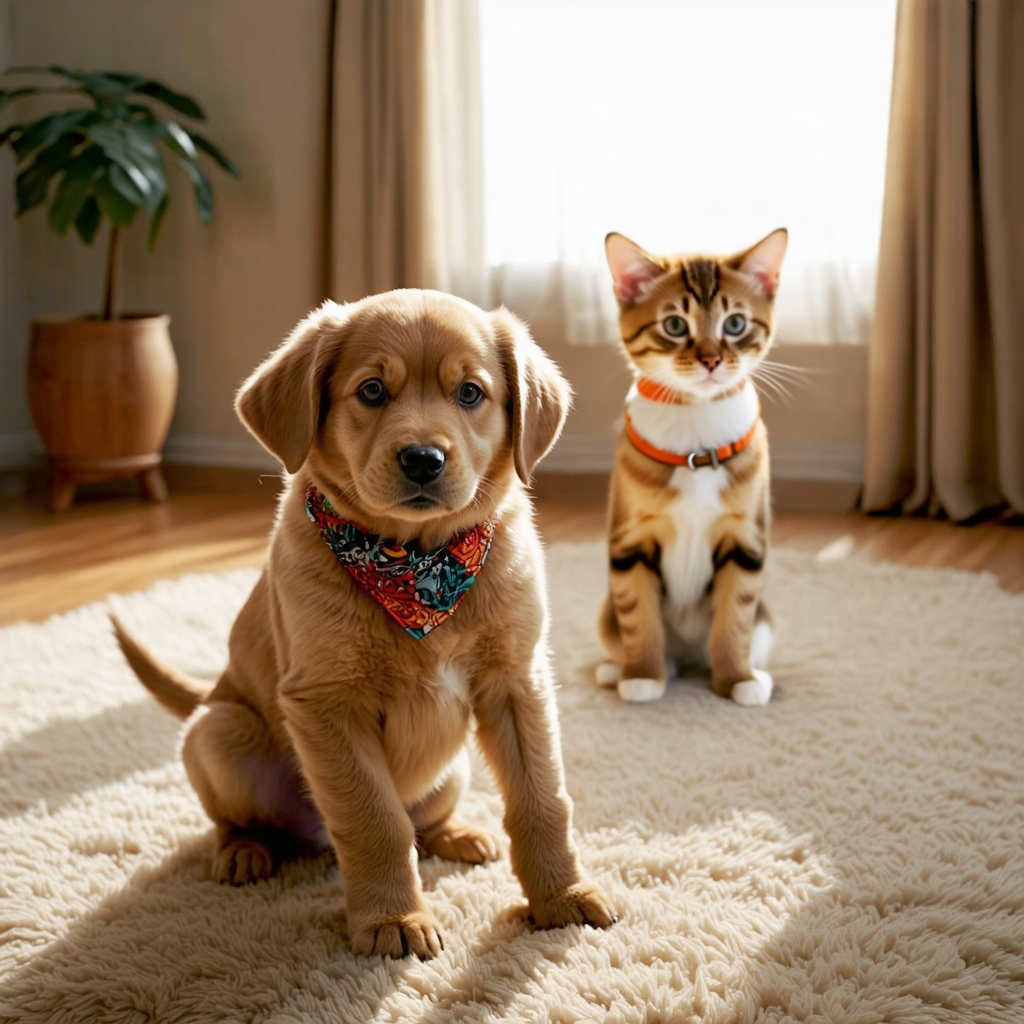

In [10]:
image = load_image(
    "https://huggingface.co/alimama-creative/SD3-Controlnet-Inpainting/resolve/main/images/dog.png"
)
mask = load_image(
    "https://huggingface.co/alimama-creative/SD3-Controlnet-Inpainting/resolve/main/images/dog_mask.png"
)

print(image.size)
width, height = image.size
prompt = "A cat is sitting next to a puppy."
generator = torch.Generator(device="cuda").manual_seed(24)


res_image = pipe(
    negative_prompt="deformed, distorted, disfigured, poorly drawn, bad anatomy, wrong anatomy, extra limb, missing limb, floating limbs, mutated hands and fingers, disconnected limbs, mutation, mutated, ugly, disgusting, blurry, amputation, NSFW",
    prompt=prompt,
    height=height,
    width=width,
    control_image= image,
    control_mask=mask,
    num_inference_steps=28,
    generator=generator,
    controlnet_conditioning_scale=0.95,
    guidance_scale=7,
).images[0]
res_image


In [15]:
image = load_image("https://huggingface.co/alimama-creative/SD3-Controlnet-Inpainting/resolve/main/images/prod.png")
mask = load_image("https://huggingface.co/alimama-creative/SD3-Controlnet-Inpainting/resolve/main/images/mask.jpeg")
width = 1024
height = 1024
prompt="a woman wearing a white jacket, black hat and black pants is standing in a field, the hat writes SD3"
generator = torch.Generator(device="cuda").manual_seed(24)
res_image = pipe(
    negative_prompt='deformed, distorted, disfigured, poorly drawn, bad anatomy, wrong anatomy, extra limb, missing limb, floating limbs, mutated hands and fingers, disconnected limbs, mutation, mutated, ugly, disgusting, blurry, amputation, NSFW',
    prompt=prompt,
    height=height,
    width=width,
    control_image = image,
    control_mask = mask,
    num_inference_steps=28,
    generator=generator,
    controlnet_conditioning_scale=0.95,
    guidance_scale=7,
).images[0]
res_image

OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacty of 23.69 GiB of which 197.69 MiB is free. Including non-PyTorch memory, this process has 23.47 GiB memory in use. Of the allocated memory 22.27 GiB is allocated by PyTorch, and 906.39 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [1]:
import torch
from diffusers import StableDiffusion3ControlNetPipeline
from diffusers.models import SD3ControlNetModel, SD3MultiControlNetModel
from diffusers.utils import load_image

controlnet = SD3ControlNetModel.from_pretrained("InstantX/SD3-Controlnet-Canny", torch_dtype=torch.float16)

pipe = StableDiffusion3ControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-3-medium-diffusers", controlnet=controlnet, torch_dtype=torch.float16
)
pipe.to("cuda")
control_image = load_image("https://huggingface.co/InstantX/SD3-Controlnet-Canny/resolve/main/canny.jpg")
prompt = "A girl holding a sign that says InstantX"
image = pipe(prompt, control_image=control_image, controlnet_conditioning_scale=0.7).images[0]
image

2024-09-17 15:43:20.724403: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-17 15:43:21.431838: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


diffusion_pytorch_model.safetensors:  63%|######2   | 744M/1.19G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

In [2]:
image

In [3]:
# !pip install transformers accelerate
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel, DDIMScheduler
from diffusers.utils import load_image
import numpy as np
import torch
import cv2
from PIL import Image

init_image = load_image(
    "https://huggingface.co/datasets/diffusers/test-arrays/resolve/main/stable_diffusion_inpaint/boy.png"
)
init_image = init_image.resize((512, 512))
generator = torch.Generator(device="cpu").manual_seed(1)

mask_image = load_image(
    "https://huggingface.co/datasets/diffusers/test-arrays/resolve/main/stable_diffusion_inpaint/boy_mask.png"
)
mask_image = mask_image.resize((512, 512))
def make_canny_condition(image):
    image = np.array(image)
    image = cv2.Canny(image, 100, 200)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    image = Image.fromarray(image)
    return image

control_image = make_canny_condition(init_image)

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/control_v11p_sd15_inpaint", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    cache_dir = "/home/khanhnq/Code/Research/GAI/Pretrained_DDPM/pytorch-stable-diffusion-finetuning/data/v1-5-pruned-emaonly.safetensors", controlnet=controlnet, torch_dtype=torch.float16)

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

# generate image
image = pipe(
    "a handsome man with ray-ban sunglasses",
    num_inference_steps=20,
    generator=generator,
    eta=1.0,
    image=init_image,
    mask_image=mask_image,
    control_image=control_image,
).images[0]

ValueError: The provided pretrained_model_name_or_path "/home/khanhnq/Code/Research/GAI/Pretrained_DDPM/pytorch-stable-diffusion-finetuning/data/v1-5-pruned-emaonly.safetensors" is neither a valid local path nor a valid repo id. Please check the parameter.

In [1]:
[1,2,3,5,6,7,8,8] - 3

TypeError: unsupported operand type(s) for -: 'list' and 'int'